In [1]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from numpy import log
import pmdarima as pm
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import shap
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')

/Users/lievegobbels/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/lievegobbels/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Loading the data set and exploratory plot

In [2]:
#read the csv file
df = pd.read_csv('new_final.csv')

df.head()

,Month,Sun_Hours,HPI,Unemployment_Rate,Total_Crimes
0,2017-01,2.1,118.06,4.6,144
1,2017-02,2.0,118.34,4.6,166
2,2017-03,3.8,118.02,4.5,194
3,2017-04,6.0,119.10,4.4,169
4,2017-05,6.3,119.38,4.4,169


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              60 non-null     object 
 1   Sun_Hours          60 non-null     float64
 2   HPI                60 non-null     float64
 3   Unemployment_Rate  60 non-null     float64
 4   Total_Crimes       60 non-null     int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 2.5+ KB


In [4]:
#change months to datetime objects
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df = df.set_index('Month')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2017-01-01 to 2021-12-01
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sun_Hours          60 non-null     float64
 1   HPI                60 non-null     float64
 2   Unemployment_Rate  60 non-null     float64
 3   Total_Crimes       60 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 2.3 KB


In [5]:
#summary statistics
df.describe()

,Sun_Hours,HPI,Unemployment_Rate,Total_Crimes
count,60.000000,60.000000,60.000000,60.000000
mean,4.391667,120.111500,4.260000,127.666667
std,2.155898,3.524746,0.382764,38.233301
min,1.000000,115.090000,3.800000,36.000000
25%,2.450000,118.050000,4.000000,102.500000
50%,4.350000,119.100000,4.200000,134.000000
75%,5.925000,121.570000,4.500000,158.000000
max,9.700000,129.720000,5.200000,194.000000


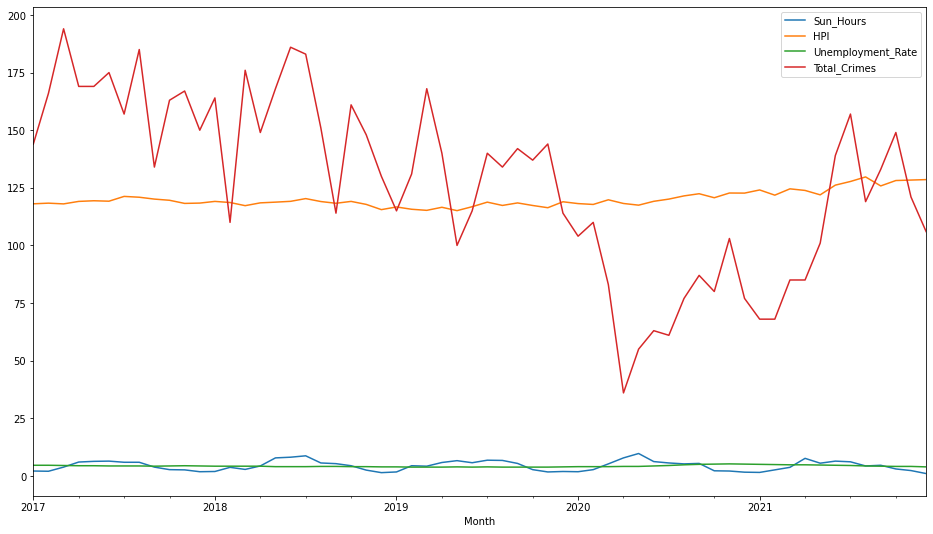

In [6]:
#plot an overview of the data
df.plot(figsize=(16,9));

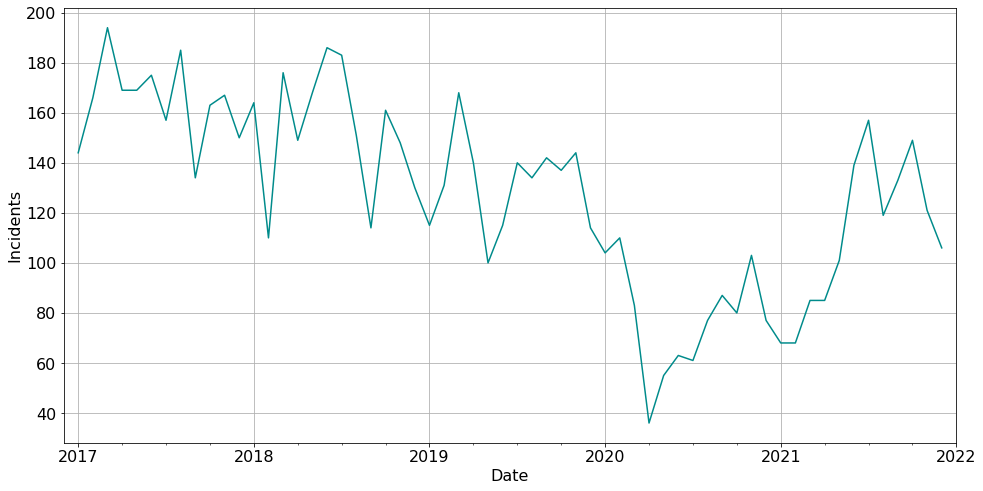

In [7]:
#plot Anti-social behavior and public order crime 2017-2021

#set figure size
figure(num=1, figsize=(16,8))

#plot observations and forecast
ax = df['Total_Crimes'].plot(label='ASB and PO crime', color=['darkcyan'])


#set labels and legend
ax.set_xlabel('Date', fontsize= 16)
ax.set_ylabel('Incidents', fontsize=16)
#plt.legend()
plt.xlim('2016-12','2022-01')
plt.grid()
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

#plt.savefig('Crimes.png')
plt.show();

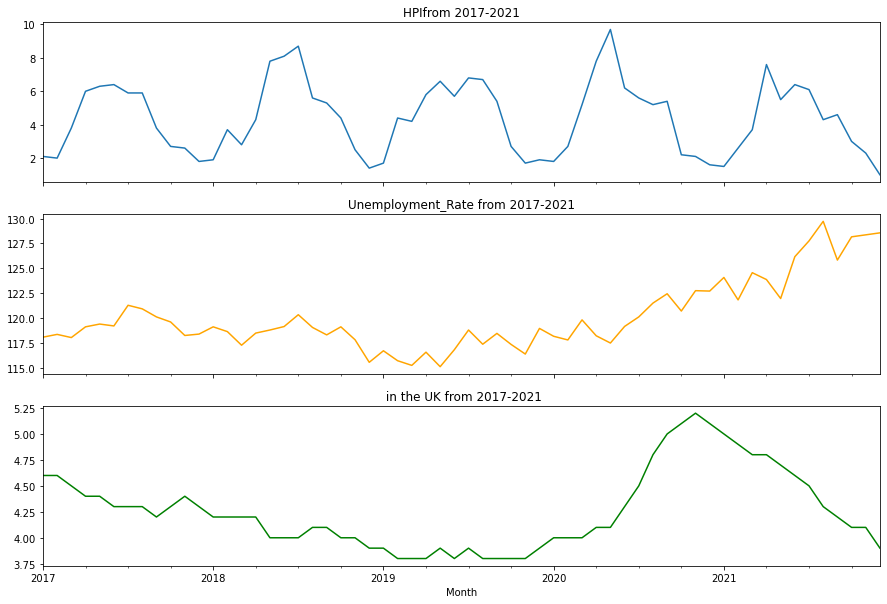

In [8]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(15,10))
df['Sun_Hours'].plot(title=df.columns[1]+'from 2017-2021',ax=ax[0])
df['HPI'].plot(title=df.columns[2]+' from 2017-2021',ax=ax[1],color='orange')
df['Unemployment_Rate'].plot(title=' in the UK from 2017-2021',ax=ax[2],color='green')
plt.gcf().set_facecolor('white');

## Statistics on the data

                   Sun_Hours       HPI  Unemployment_Rate  Total_Crimes
Sun_Hours           1.000000 -0.067900          -0.148295      0.014524
HPI                -0.067900  1.000000           0.439959     -0.171146
Unemployment_Rate  -0.148295  0.439959           1.000000     -0.332049
Total_Crimes        0.014524 -0.171146          -0.332049      1.000000


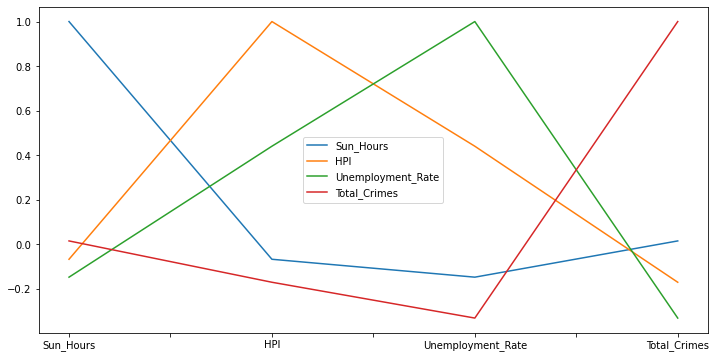

In [9]:
#plot the pearson correlation (linear relationship) between the variables
df_corr_pearson = df.corr()

print(df_corr_pearson)
df_corr_pearson.plot(figsize=(12,6));


                   Sun_Hours       HPI  Unemployment_Rate  Total_Crimes
Sun_Hours           1.000000  0.035314          -0.080432      0.124006
HPI                 0.035314  1.000000           0.620402     -0.182502
Unemployment_Rate  -0.080432  0.620402           1.000000     -0.185858
Total_Crimes        0.124006 -0.182502          -0.185858      1.000000


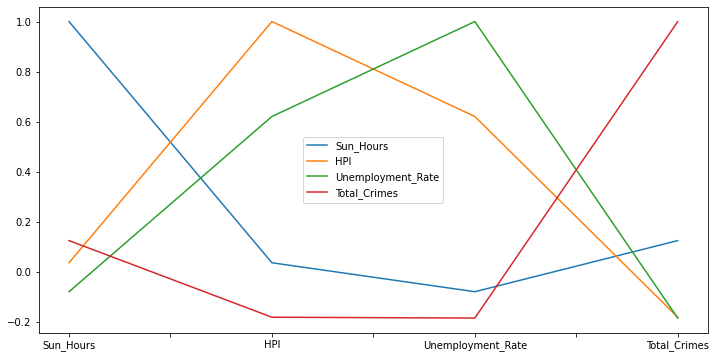

In [10]:
#plot the spearman correlation (relationship on at least ordinal scale/monotonic) between the variables
df_corr_spearman = df.corr(method='spearman')

print(df_corr_spearman)
df_corr_spearman.plot(figsize=(12,6));


In [11]:
result = adfuller(df['Total_Crimes'])
print('Sum ASB and public order crime')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['Sun_Hours'])
print('Sun hours')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['HPI'])
print('HPI')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['Unemployment_Rate'])
print('Unemployment rate')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Sum ASB and public order crime
ADF Statistic: -2.621184
p-value: 0.088698
Sun hours
ADF Statistic: -7.121604
p-value: 0.000000
HPI
ADF Statistic: 0.628427
p-value: 0.988296
Unemployment rate
ADF Statistic: -2.080777
p-value: 0.252314


The p-value is >0.05 which means that it is non-stationary for all features except Sun Hours. Non-stationary means that variances and covariances change over time so they are unpredictable and cannot be modeled or forecasted
that is why you first have to find the order of differencing to make it stationary.
ARIMA models are designed to solve non-stationary data, if we try to predict stationary data, so public order, this can lead to over-differentiation and biased results. 

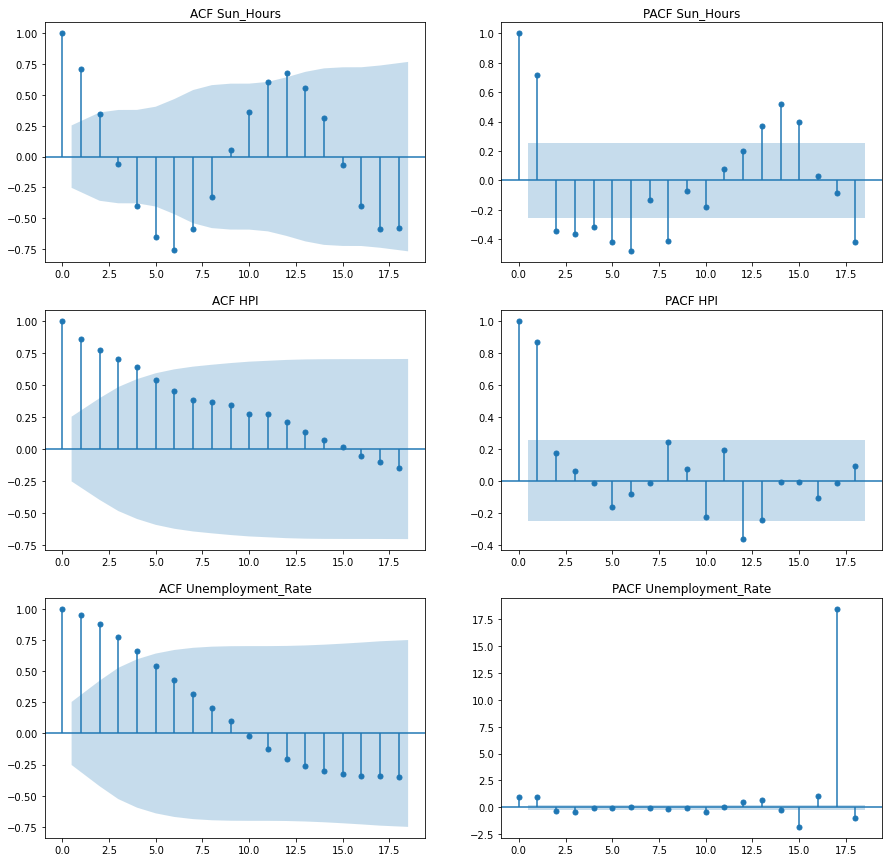

In [12]:
#plot autocorrelation of time series data 
fig,ax = plt.subplots(3,2,figsize=(15,15))
plot_acf(df['Sun_Hours'],title='ACF Sun_Hours',ax=ax[0,0])
plot_pacf(df['Sun_Hours'],title='PACF Sun_Hours',ax=ax[0,1])

plot_acf(df['HPI'],title='ACF HPI',ax=ax[1,0])
plot_pacf(df['HPI'],title='PACF HPI',ax=ax[1,1])

plot_acf(df['Unemployment_Rate'],title='ACF Unemployment_Rate',ax=ax[2,0])
plot_pacf(df['Unemployment_Rate'],title='PACF Unemployment_Rate',ax=ax[2,1])
plt.gcf().set_facecolor('white');

Here we can add some explanation of the statistical results and especially the ACF and PACF plots. We can then link this to SARIMAX. 

## Constructing the ARIMA model

Among the most ‘seasoned’ techniques for time series forecast, there is ARIMA, which is the acronym of Auto Regressive Integrated Moving Average. Even though ARIMA has shown evidence for working fairly, it has the major pitfall of not being able to handle seasonality.
SARIMAX stands for ‘Seasonal Auto Regressive Integrated Moving Average with exogenus factors’
Accordingly, SARIMAX represents an ‘upgrade’ to the seasoned ARIMA model. In a nutshell, such an upgrade is performed for adding seasonality and exogenous factors. 

In order to fit a SARIMAX, we need to define values for parameters p, d and q, where:
 
* p is the number of autoregressive terms
* d is the number of non-seasonal differences needed for stationarity
* q is the number of lagged forecast errors in the prediction equation

Fitting a SARIMAX involves an iterative search of an ‘optimal combo’ of non-seasonal p, d, q along with seasonal p, d, q. In our case, we take the three following steps sequentially:
* Define p, d and q parameters to take any value between 0 and 2
* Generate all different combinations of p, q and q triplets
* Define seasonal p, d and q parameters in function of p, d, q with a maximum value of 12.
* Generate all different combinations of seasonal p, q and q triplets


In [13]:
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(df[['Sun_Hours']], df[['HPI']], df[['Unemployment_Rate']], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (            Sun_Hours
Month                
2017-01-01        2.1
2017-02-01        2.0
2017-03-01        3.8
2017-04-01        6.0
2017-05-01        6.3
2017-06-01        6.4
2017-07-01        5.9
2017-08-01        5.9
2017-09-01        3.8
2017-10-01        2.7
2017-11-01        2.6
2017-12-01        1.8
2018-01-01        1.9
2018-02-01        3.7
2018-03-01        2.8
2018-04-01        4.3
2018-05-01        7.8
2018-06-01        8.1
2018-07-01        8.7
2018-08-01        5.6
2018-09-01        5.3
2018-10-01        4.4
2018-11-01        2.5
2018-12-01        1.4
2019-01-01        1.7
2019-02-01        4.4
2019-03-01        4.2
2019-04-01        5.8
2019-05-01        6.6
2019-06-01        5.7
2019-07-01        6.8
2019-08-01        6.7
2019-09-01        5.4
2019-10-01        2.7
2019-11-01        1.7
2019-12-01        1.9
2020-01-01        1.8
2020-02-01        2.7
2020-03-01        5.2
2020-04-01        7

We then need to find the most optimal combo of parameters:

In [14]:
warnings.filterwarnings("ignore") 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=train.Rides,\
                                            trend='n',\
                                            order=(1,0,1),\
                                            seasonal_order=(1,0,1,12))

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Finally, we can fit the model and obtain some diagnostics:

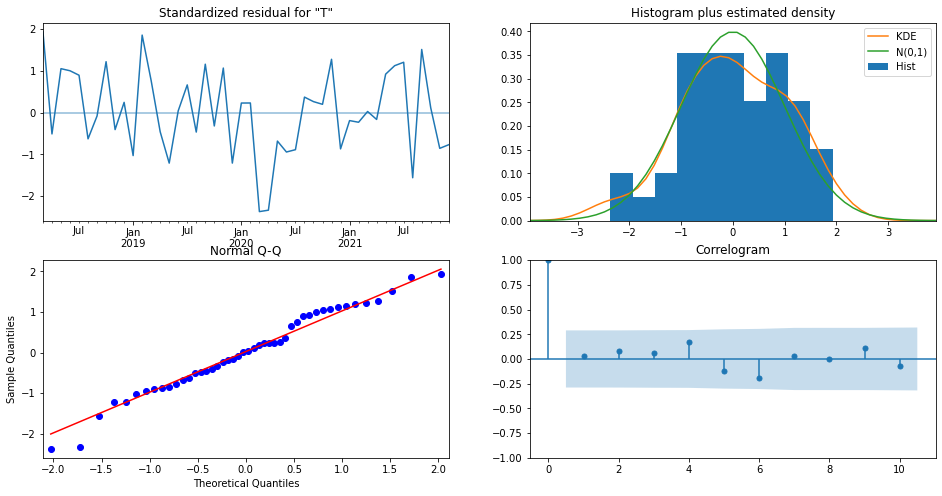

In [15]:
mod = sm.tsa.statespace.SARIMAX(df[['Total_Crimes']],
                                exog=df[['Sun_Hours', 'HPI', 'Unemployment_Rate']],
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [16]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Total_Crimes   No. Observations:                   60
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -202.583
Date:                            Mon, 04 Apr 2022   AIC                            421.165
Time:                                    11:17:47   BIC                            435.795
Sample:                                01-01-2017   HQIC                           426.646
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Sun_Hours             1.8282      2.731      0.669      0.503      -3.525       7.182
HPI                   2.2423      0.717      3.126      0.002       0.837       3.648
Unemployment_Rate   -41.0532     19.918     -2.061      0.039     -80.092      -2.014
ar.L1                 0.3161      0.248      1.273      0.203      -0.171       0.803
ma.L1                 0.4940      0.285      1.734      0.083      -0.064       1.052
ar.S.L12              0.4180      0.135      3.091      0.002       0.153       0.683
ma.S.L12             -0.3220      0.303     -1.064      0.287      -0.915       0.271
sigma2              378.1495    100.137      3.776      0.000     181.885     574.414
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.81   Prob(JB):                         0.73
Heteroskedasticity (H):               0.77   Skew:                            -0.24
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Above, Prob(Q) and Prob(JB) are interesting test results as they help to improve the model:
* Prob(Q) = 0.58 > 0.05.  We shouldn’t reject the null hypothesis that the residuals are uncorrelated so the residuals are not correlated
* Prob(JB) = 0.57 > 0.05. We do not reject the null hypothesis that the residuals are normally distributed. 

This means that we should increase _p_ or _q_. 


In the next cell, the residuals are described and plotted. Ideally, the mean is around zero, which would indicate a perfect fit. For the current model, the residual mean is 3.670. 

               0
count  60.000000
mean   10.039013
std    28.421586
min   -46.104528
25%    -9.511508
50%     4.984847
75%    24.783661
max    80.011815


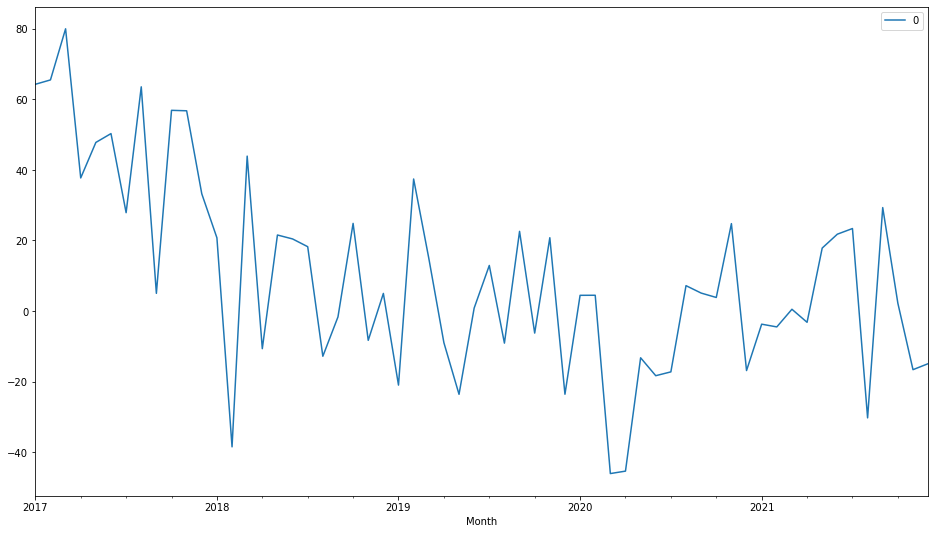

In [17]:
#plot the residuals
residuals = pd.DataFrame(results.resid)
residuals.plot(figsize=(16,9));

print(residuals.describe())

### Predicting

In the following, the observed and predicted data is plotted to give a visual indication of the performance of the model. Next to this, the MAE, RMSE MAPE and $R^2$ are calculated, once again to assess the model's performance. 

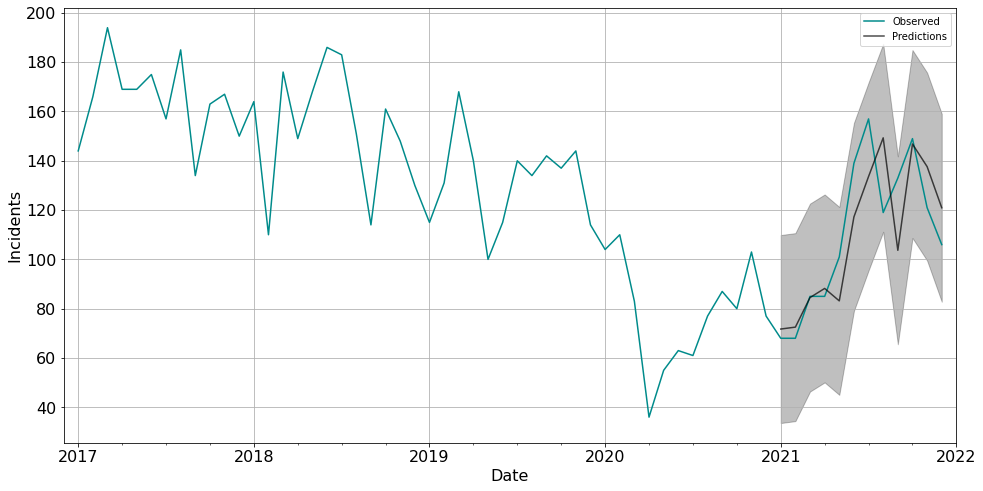

In [18]:
#predict months 49-60 (so entire 2021)
start_prediction = 48 
pred = results.get_prediction(start=start_prediction, dynamic=False)
pred_ci = pred.conf_int()

#set figure size
figure(num=1, figsize=(16,8))

#plot observations and predictions
ax = df['Total_Crimes'].plot(label='Observed', color=['darkcyan'])
mean = pred.predicted_mean
mean.plot(ax=ax, label='Predictions', alpha=.7, color='k')

#plot confidence interval
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

#set labels and legend
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Incidents', fontsize=16)
plt.legend()
plt.xlim('2016-12','2022-01')
plt.grid()
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

#plt.savefig('ARIMA-prediction.png')
plt.show();

In [19]:
#performance results
test = df['Total_Crimes'].iloc[48:]

mse = mean_absolute_error(test, mean)
rmse = sqrt(mean_squared_error(test, mean))
mape = mean_absolute_percentage_error(test, mean)
rsquared = r2_score(test, mean)

print('Test MAE: %.3f,' % mse, 'Test RMSE: %.3f' % rmse, 'Test MAPE: %.3f' % mape, 'Test R-squared: %.3f' % rsquared)

Test MAE: 14.030, Test RMSE: 17.482 Test MAPE: 0.118 Test R-squared: 0.639


### Forecasting

In the following, the observed and forecasted data until 2024 is plotted to give a visual indication of the performance of the model. Since there are no true values, it is not possible to provide performance statistics like MAE and RMSE.

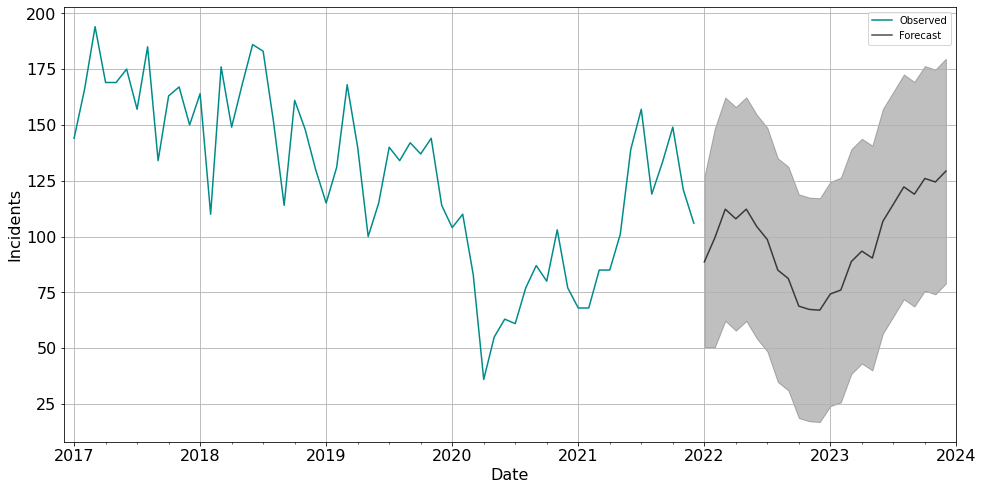

In [20]:
#reshape exogenous variables for forecasting
exog = df[['Sun_Hours', 'HPI', 'Unemployment_Rate']].iloc[36:60]

#get forecasting
forecast = results.get_forecast(steps=24, exog=exog)
forecast_ci = forecast.conf_int()

#set figure size
figure(num=1, figsize=(16,8))

#plot observations and forecast
ax = df['Total_Crimes'].plot(label='Observed', color=['darkcyan'])
mean_f = forecast.predicted_mean
mean_f.plot(ax=ax, label='Forecast', alpha=.7, color='k') 

ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.25)

#set labels and legend
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Incidents', fontsize=16)
plt.legend()
plt.xlim('2016-12','2024-01')
plt.grid()
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

#plt.savefig('ARIMA-forecast.png')
plt.show();


## Feature Importance Decomposition and Uncertainty Quantification

Below, the relative importance of each feature is presented.

[0.25425526 0.19356259 0.55218215]


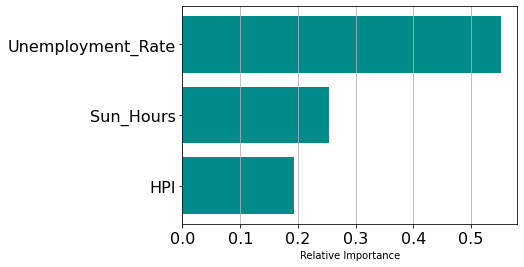

In [21]:
rf = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=2)
rf.fit(df[['Sun_Hours', 'HPI', 'Unemployment_Rate']], df[['Total_Crimes']])
print(rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)

features = df[['Sun_Hours', 'HPI', 'Unemployment_Rate']].columns
#plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='darkcyan', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid(axis='x')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

#plt.savefig('Features.png', bbox_inches = "tight")
plt.show()

Here, different prediction intervals (upper, mean, lower bounds) are given for different prediction intervals. Currently, this only regards the first prediction, so 01-01-2021. 

In [22]:
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    ci = pred.conf_int(alpha=a)
    #print(ci)
    print('%.1f%% Confidence Interval: mean of %.3f, low %.3f and up %.3f' % ((1-a)*100, mean[0], ci['lower Total_Crimes'][0], ci['upper Total_Crimes'][0]))
    
    

80.0% Confidence Interval: mean of 71.745, low 46.811 and up 96.678
90.0% Confidence Interval: mean of 71.745, low 39.743 and up 103.747
95.0% Confidence Interval: mean of 71.745, low 33.612 and up 109.877
99.0% Confidence Interval: mean of 71.745, low 21.630 and up 121.860


In [23]:
print('Forecast:')
print(mean_f)
print("Confidence intervals:")
print(forecast.conf_int())

Forecast:
2022-01-01     88.622121
2022-02-01     99.376339
2022-03-01    112.251034
2022-04-01    107.939936
2022-05-01    112.258633
2022-06-01    104.453139
2022-07-01     98.656325
2022-08-01     84.961070
2022-09-01     81.190824
2022-10-01     68.815886
2022-11-01     67.350001
2022-12-01     67.032815
2023-01-01     74.274537
2023-02-01     76.041495
2023-03-01     88.793648
2023-04-01     93.460030
2023-05-01     90.372181
2023-06-01    106.807619
2023-07-01    114.486641
2023-08-01    122.246730
2023-09-01    118.976525
2023-10-01    126.023032
2023-11-01    124.449876
2023-12-01    129.303231
Freq: MS, Name: predicted_mean, dtype: float64
Confidence intervals:
            lower Total_Crimes  upper Total_Crimes
2022-01-01           50.506558          126.737685
2022-02-01           50.324650          148.428028
2022-03-01           62.239841          162.262228
2022-04-01           57.833901          158.045971
2022-05-01           62.143134          162.374133
2022-06-01     